In [16]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import logit
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_excel('data/data.xlsx')
df['groups_idx'] = df['group']
df['updrs_diff'] = df['w24_updrsiii'] - df['w0_updrsiii']
df['seheps_diff'] = df['w8_seheps'] - df['seheps']
df['w8-w0_mep'] = df['w8_mep'] - df['w0_mep']
df['w24-w8_mep'] = df['w24_mep'] - df['w8_mep']
df['w24-w0_mep'] = df['w24_mep'] - df['w0_mep']
df['w8-24_adh'] = df['w8-24_total'] > (0.7 * 800)
df['W1_mep_diff'] = df['w0_mep'] - df['w1_mep']

# Adjust group indices
df.loc[df['group'] == 0, 'groups_idx'] = 1
df.loc[df['group'] == 1, 'groups_idx'] = 2
df['groups_idx_seheps'] = df['groups_idx']
df.loc[(df['group'] == 0) & (df['w8_seheps'] >= 59), 'groups_idx_seheps'] = 3
df.loc[(df['group'] == 1) & (df['w8_seheps'] >= 59), 'groups_idx_seheps'] = 4

df.columns

Index(['ID', 'group', 'gender', 'moca', 'age', 'duration', 'dopamin_therapy',
       'led_mg', 'advanced_therapies', 'education_years', 'Work situation',
       'Marital status', 'height', 'weight', 'bmi', 'seheps', 'w1_mep',
       'w1_vpcf', 'w0-2', 'w2-4', 'w4-6', 'w6-8', 'w0-8_total', 'w8-12',
       'w12-16', 'w16-20', 'w20-24', 'w8-24_total', 'w0_updrsiii', 'w0_hy',
       'w0_mep', 'w0_vpcf', 'w8_seheps', 'w8_updrsiii', 'w8_mep', 'w8_vpcf',
       'w24_updrsiii', 'w24_mep', 'groups_idx', 'updrs_diff', 'seheps_diff',
       'w8-w0_mep', 'w24-w8_mep', 'w24-w0_mep', 'w8-24_adh', 'W1_mep_diff',
       'groups_idx_seheps'],
      dtype='object')

## Splitting into groups and basic data description
Splitting the data into control (CG) and experimental (EG) groups, naming the groups, and basic variable description.

In [17]:
# Split into groups and basic description
CG = df[df['group'] == 0].copy()  # Control group
EG = df[df['group'] == 1].copy()  # Experimental group
group_names = ['CG', 'EG']
group_names_seheps = ['CG SEHEPS <59', 'EG SEHEPS <59', 'CG SEHEPS >= 59', 'EG SEHEPS >= 59']

# Basic description of selected variables
params = ['moca','age','duration','education_years','height','weight','bmi','led_mg','w0_updrsiii','seheps','w0_mep','w0_vpcf']
display(df[params].describe().applymap(lambda x: round(x, 3)))

,moca,age,duration,education_years,height,weight,bmi,led_mg,w0_updrsiii,seheps,w0_mep,w0_vpcf
count,75.000,75.000,75.000,75.000,75.000,75.000,75.000,62.000,75.000,75.000,75.000,75.000
mean,26.107,65.453,7.147,15.253,173.253,79.053,26.121,683.194,17.267,40.240,133.413,458.493
std,2.934,9.154,5.208,2.886,9.023,18.778,4.662,295.486,9.095,16.261,46.384,131.150
min,19.000,43.000,1.000,9.000,158.000,48.000,17.647,150.000,2.000,9.000,47.000,113.000
25%,24.000,59.000,4.000,13.000,166.000,67.500,22.903,450.000,11.000,28.500,95.500,366.500
50%,26.000,67.000,6.000,15.000,172.000,76.000,25.469,600.000,16.000,39.000,133.000,445.000
75%,29.000,71.500,8.000,18.000,179.500,90.000,29.013,1000.000,21.000,53.000,165.000,534.500
max,30.000,80.000,29.000,22.000,195.000,140.000,36.818,1300.000,48.000,72.000,260.000,745.000


## Comparison of groups in demographic and clinical parameters at baseline
Comparison of control and experimental groups using t-test and normality test for selected parameters.

In [18]:
from scipy.stats import fisher_exact

# Baseline demographic characteristics table

# Define mapping for display names and units
baseline_params = [
    ('gender', 'Sex (Male/Female)'),
    ('age', 'Age (y)'),
    ('height', 'Height (m)'),
    ('weight', 'Weight (kg)'),
    ('bmi', 'BMI'),
    ('education_years', 'Education (y)'),
    ('duration', 'Disease duration (y)'),
    ('w0_hy', 'Hoehn & Yahr'),
    ('w0_updrsiii', 'MDS-UPDRS III, ON'),
    ('moca', 'MoCa'),
    ('led_mg', 'LEDD (mg/day)'),
    ('seheps', 'SEHEPS'),
    ('w0_mep', 'Maximum expiratory pressure (cmH2O)')
]

rows = []
for col, label in baseline_params:
    if col == 'gender':
        # Count males and females
        cg_m = (CG['gender'] == 'M').sum()
        cg_f = (CG['gender'] == 'F').sum()
        eg_m = (EG['gender'] == 'M').sum()
        eg_f = (EG['gender'] == 'F').sum()
        row = [label, f"{cg_m}/{cg_f}", f"{eg_m}/{eg_f}", '']
        # Fisher's exact test for gender distribution
        table = np.array([[cg_m, cg_f], [eg_m, eg_f]])
        _, p_val_gender = fisher_exact(table)
        row[3] = f"{p_val_gender:.3f}"
    else:
        cg_vals = CG[col].dropna()
        eg_vals = EG[col].dropna()
        cg_mean = cg_vals.mean()
        cg_std = cg_vals.std()
        eg_mean = eg_vals.mean()
        eg_std = eg_vals.std()
        # t-test
        t_stat, p_val = stats.ttest_ind(cg_vals, eg_vals, nan_policy='omit')
        row = [
            label,
            f"{cg_mean:.1f} ({cg_std:.1f})",
            f"{eg_mean:.1f} ({eg_std:.1f})",
            f"{p_val:.3f}"
        ]
    rows.append(row)

# Create DataFrame for display
baseline_table = pd.DataFrame(
    rows,
    columns=['Measure', 'Control group (n=38)', 'Experimental group (n=37)', 'P-value']
)
display(baseline_table)

,Measure,Control group (n=38),Experimental group (n=37),P-value
0,Sex (Male/Female),21/17,24/13,0.482
1,Age (y),65.4 (9.5),65.5 (8.9),0.995
2,Height (m),173.7 (8.9),172.8 (9.3),0.678
3,Weight (kg),78.3 (19.2),79.8 (18.5),0.742
4,BMI,25.8 (5.0),26.5 (4.4),0.509
5,Education (y),14.9 (2.9),15.6 (2.9),0.244
6,Disease duration (y),7.0 (5.7),7.3 (4.7),0.807
7,Hoehn & Yahr,2.0 (0.5),2.0 (0.5),0.832
8,"MDS-UPDRS III, ON",17.1 (8.8),17.5 (9.5),0.858
9,MoCa,26.3 (3.0),25.9 (2.9),0.643


In [ ]:
# Prepare data for boxplots
cg_weeks = ['w8-12', 'w12-16', 'w16-20', 'w20-24']
eg_weeks = ['w8-12', 'w12-16', 'w16-20', 'w20-24']

data = [np.asarray(CG[w].dropna()) for w in cg_weeks] + [np.asarray(EG[w].dropna()) for w in eg_weeks]
labels = [
    'CG W8-12', 'CG W12-16', 'CG W16-20', 'CG W20-24',
    'EG W8-12', 'EG W12-16', 'EG W16-20', 'EG W20-24'
]

fig, ax = plt.subplots(figsize=(12, 6))
box = ax.boxplot(data, patch_artist=True, labels=labels)

# Red dashed line at y=250
ax.axhline(250, color='red', linestyle='--', linewidth=2, label='Prescribed number of expiratory maneuvers')

# Y label
ax.set_ylabel('Number of Expiratory Maneuvers (MEP)')

# Add legend
ax.legend(loc='upper right')

# Draw line and annotate p-value and Cohen's d
x1, x2 = 4, 8  # CG W20-24 (index 4) and EG W20-24 (index 8), but boxplot is 1-based
y, h = max(np.nanmax(data[3]), np.nanmax(data[7])) + 30, 20
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], color='black')
ax.text((x1+x2)/2, y+h+5, "p=0.01, cohen d=0.97", ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

KeyError: 'w8_12'

## Adherence analysis (week 0–8 and 8–24)
Comparison of adherence between control and experimental groups using Mann-Whitney U test and boxplots.

KeyError: 'w0_8_total'

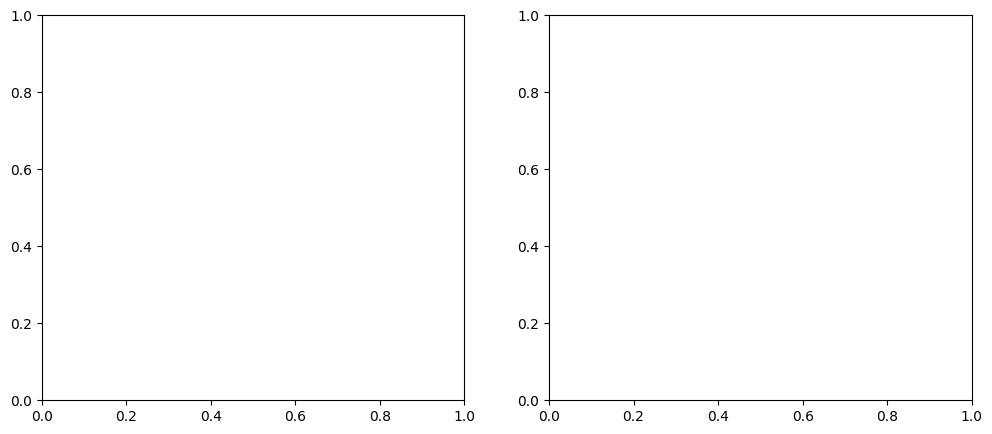

In [11]:
# Adherence analysis for week 0–8 and 8–24
adherence_params = ['w0_8_total', 'w8-24_total']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, param in enumerate(adherence_params):
    # Mann-Whitney U test (ranksum equivalent)
    stat, p_val = stats.mannwhitneyu(CG[param].dropna(), EG[param].dropna(), alternative='two-sided')
    sns.boxplot(x=df['groups_idx'], y=df[param], ax=axes[i])
    axes[i].set_title(f'{param} p={p_val:.3f}')
    axes[i].set_xticklabels(group_names)
    axes[i].set_xlabel('Group')
    axes[i].set_ylabel(param)
plt.tight_layout()
plt.show()

# Calculate group statistics for adherence parameters
def group_stats(param):
    return pd.DataFrame({
        'Group': group_names,
        'Mean': [CG[param].mean(), EG[param].mean()],
        'Std': [CG[param].std(), EG[param].std()],
        'Median': [CG[param].median(), EG[param].median()]
    })

for param in adherence_params:
    display(group_stats(param))

## Change in expiratory muscle strength (MEP) after training
Analysis of MEP changes (week 0–8, 8–24, 0–24) in both groups using t-tests and boxplots.

In [ ]:
# MEP change analysis (week 0–8, 8–24, 0–24)
mep_params = ['w8_w0_mep', 'w24_w8_mep', 'w24_w0_mep']
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df[mep_params], orient='h')
ax.set_yticklabels(['w8 - w0', 'w24 - w8', 'w24 - w0'])
ax.set_title('MEP change in all subjects')
ax.set_xlabel('MEP change')
plt.show()

# T-tests between groups for each MEP change parameter
for i, param in enumerate(mep_params):
    t_stat, p_val = stats.ttest_ind(CG[param].dropna(), EG[param].dropna(), nan_policy='omit')
    print(f'{param}: t-test p-value = {p_val:.3f}')

## Logistic regression: SEHEPS score and adherence
Logistic regression to predict non-adherence (less than 70% of maneuvers) from SEHEPS score at week 8 in the experimental group.

In [ ]:
# Logistic regression: SEHEPS score and adherence in experimental group
MDT = EG.copy()  # Only experimental group
MDT['w8_24_adh_bin'] = MDT['w8_24_adh'].astype(int)

# Fit logistic regression model
model = sm.Logit(MDT['w8_24_adh_bin'], sm.add_constant(MDT['w8_seheps']))
result = model.fit(disp=0)
print(result.summary())

# Predict probabilities and classes
predicted_prob = result.predict(sm.add_constant(MDT['w8_seheps']))
predicted_class = predicted_prob > 0.5

# Confusion matrix and metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
cm = confusion_matrix(MDT['w8_24_adh_bin'], predicted_class)
print('Confusion matrix:')
print(cm)
accuracy = accuracy_score(MDT['w8_24_adh_bin'], predicted_class)
sensitivity = recall_score(MDT['w8_24_adh_bin'], predicted_class)
specificity = recall_score(MDT['w8_24_adh_bin'], predicted_class, pos_label=0)
print(f'Accuracy: {accuracy:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')

# Visualization
plt.figure(figsize=(7,5))
plt.scatter(MDT['w8_seheps'], MDT['w8_24_adh_bin'], label='Data', alpha=0.7)
plt.plot(MDT['w8_seheps'], predicted_prob, 'r*', label='Predicted probability')
plt.xlabel('SEHEPS (week 8)')
plt.ylabel('Adherence (binary)')
plt.legend()
plt.title('Logistic regression: SEHEPS vs. adherence')
plt.show()

## Correlation analysis: Adherence and MEP/SEHEPS
Correlation between adherence (w8_24_total) and MEP/SEHEPS in both groups.

In [ ]:
# Correlation between adherence and MEP/SEHEPS in both groups
def correlation_and_plot(G1, G2, x, y):
    import matplotlib.lines as mlines
    color_cg = 'tab:blue'
    color_eg = 'tab:orange'
    # Data
    Ga1, Ga2 = G1[x], G1[y]
    Gb1, Gb2 = G2[x], G2[y]
    # Correlations
    rho_cg, p_cg = stats.spearmanr(Ga1, Ga2, nan_policy='omit')
    rho_eg, p_eg = stats.spearmanr(Gb1, Gb2, nan_policy='omit')
    # Plot
    plt.scatter(Ga1, Ga2, color=color_cg, label=f'CG rho={rho_cg:.2f} p={p_cg:.3f}')
    plt.scatter(Gb1, Gb2, color=color_eg, label=f'EG rho={rho_eg:.2f} p={p_eg:.3f}')
    # Fit lines
    z_cg = np.polyfit(Ga1, Ga2, 1)
    z_eg = np.polyfit(Gb1, Gb2, 1)
    x_range = np.linspace(min(Ga1.min(), Gb1.min()), max(Ga1.max(), Gb1.max()), 100)
    plt.plot(x_range, np.polyval(z_cg, x_range), color=color_cg, linestyle='--')
    plt.plot(x_range, np.polyval(z_eg, x_range), color=color_eg, linestyle='--')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.grid(True)
    plt.show()

# Correlation: adherence vs. w24_mep
correlation_and_plot(CG, EG, 'w8_24_total', 'w24_mep')
# Correlation: adherence vs. w8_seheps
correlation_and_plot(CG, EG, 'w8_24_total', 'w8_seheps')

## Difference analysis: SEHEPS and UPDRS
Comparison of SEHEPS and UPDRS III differences between groups using t-tests and boxplots.

In [ ]:
# Difference analysis: SEHEPS and UPDRS III
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# SEHEPS difference
stat1, p_val1 = stats.ttest_ind(CG['seheps_diff'].dropna(), EG['seheps_diff'].dropna(), nan_policy='omit')
sns.boxplot(x=df['groups_idx'], y=df['seheps_diff'], ax=axes[0])
axes[0].set_title(f'SEHEPS W8-W0 p={p_val1:.3f}')
axes[0].set_xticklabels(group_names)
axes[0].set_xlabel('Group')
axes[0].set_ylabel('SEHEPS difference')
# UPDRS III difference
stat2, p_val2 = stats.ttest_ind(CG['updrs_diff'].dropna(), EG['updrs_diff'].dropna(), nan_policy='omit')
sns.boxplot(x=df['groups_idx'], y=df['updrs_diff'], ax=axes[1])
axes[1].set_title(f'UPDRS III w24-W0 p={p_val2:.3f}')
axes[1].set_xticklabels(group_names)
axes[1].set_xlabel('Group')
axes[1].set_ylabel('UPDRS III difference')
plt.tight_layout()
plt.show()

## UPDRS III time course analysis
Boxplot of UPDRS III scores over time for both groups.

In [ ]:
# UPDRS III time course analysis
updrs_weeks = ['w8_12', 'w12_16', 'w16_20', 'w20_24']
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df[updrs_weeks])
ax.set_xticklabels(['w8-12', 'w12-16', 'w16-20', 'w20-24'])
ax.set_title('UPDRS III time course (all subjects)')
ax.set_ylabel('UPDRS III')
plt.show()